In [16]:
import pandas as pd
import pandas.tseries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np 
from statsmodels.tsa.arima_model import ARIMA


In [2]:
by_year_df = pd.read_excel('Data/Total_immigration_by_year.xlsx') 
by_year_df.set_index('Year', inplace = True) #set index as year
by_year_df.index= by_year_df.index.astype(str) #change to str for date time format
by_year_df.index = pd.to_datetime(by_year_df.index)#, format='%d/%m/%y') #convert index to correct date time for future slicing
total_immigration = by_year_df['1820-01-01':]
total_immigration.head()
total_immigration.shape


(198, 1)

In [3]:
ts = total_immigration

In [5]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 32, center = False).mean()
    rolstd = TS.rolling(window = 32, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['Number']) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput2 = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput2['Critical Value (%s)'%key] = value
    print (dfoutput2)

In [14]:
data = pd.Series(np.log(immigration_array), index=index)
# data

Text(0,0.5,'log(Total_immigration_by_year)')

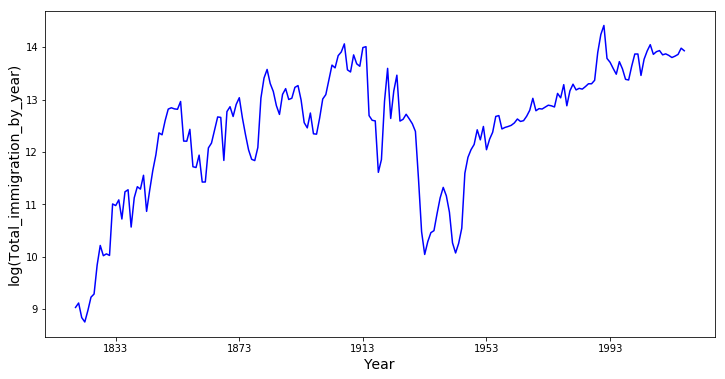

In [15]:
fig = plt.figure(figsize=(12,6))
plt.plot(data, color="blue")
plt.xlabel("Year", fontsize=14)
plt.ylabel("log(Total_immigration_by_year)", fontsize=14)
# plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(data)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-2.6829608634726316, 0.07703347923039643, 7, 190, {'1%': -3.4652439354133255, '5%': -2.8768752281673717, '10%': -2.574944653739612}, 122.4391885939828)


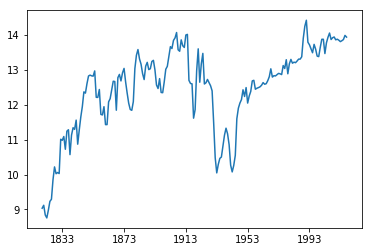

In [7]:
ts_log = np.log(ts)
plt.plot(ts_log)

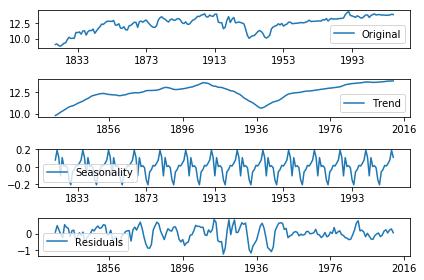

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq = 15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

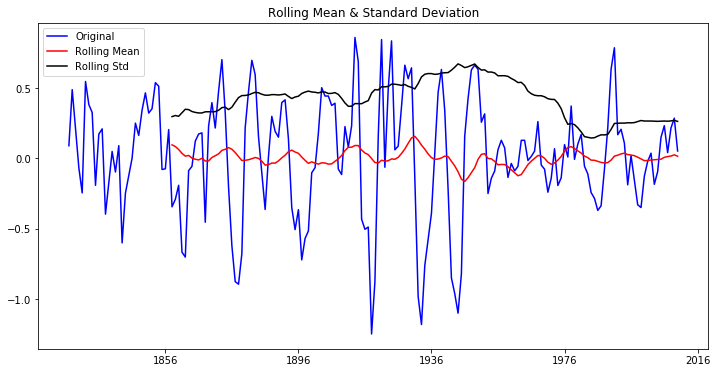

Results of Dickey-Fuller Test:
Test Statistic                -6.762239e+00
p-value                        2.773379e-09
#Lags Used                     1.000000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64


In [46]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
stationarity_check(ts_log_decompose)

In [54]:
# ts_log_diff = ts_log - ts_log.shift()
# ts_log_diff.head()
# ts_log_diff.dropna(inplace=True)
# stationarity_check(ts_log_diff)
# ts_log_diff.isna().sum()
print(ts_log_diff.shape)
print(ts_log.shape)
ts_log_diff = ts_log_diff.astype('float64')
ts_log_diff.shape

(197, 1)
(198, 1)


(197, 1)

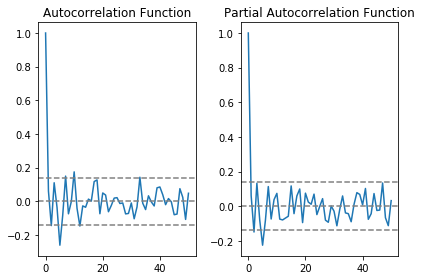

In [55]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=50)
lag_pacf = pacf(ts_log_diff, nlags=50, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 23.8125')

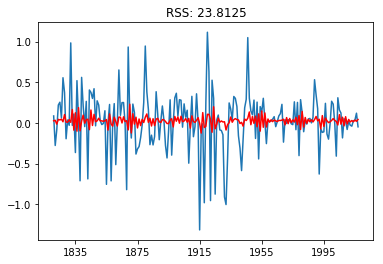

In [62]:
# using 5 and 2 
# p – The lag value where the PACF chart crosses the upper confidence interval for the first time. 
# If you notice closely, in this case p=2.
# q – The lag value where the ACF chart crosses the upper confidence interval for the first time. 
# If you notice closely, in this case q=2.

model = ARIMA(ts_log_diff, order=(1, 0, 1))  
# ARIMA()
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff.Number)**2))

In [90]:

# ts_log_diff = ts_log - ts_log.shift()
# plt.plot(ts_log_diff)
# ts_log_diff.dropna(inplace=True)
# stationarity_check(ts_log_diff)
# ts_log_diff.Number


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 23.6829')

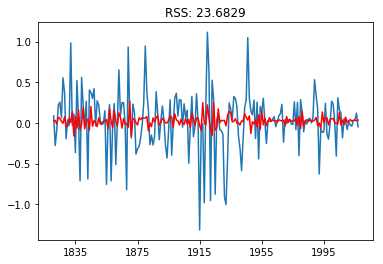

In [42]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues- ts_log_diff.Number)**2))

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 22.7511')

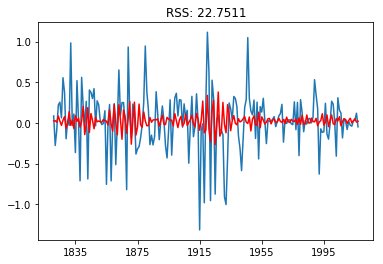

In [38]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff.Number)**2))

In [2]:
ts_log.head() 

NameError: name 'ts_log' is not defined

In [39]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Year
1821-01-01    0.024940
1822-01-01    0.025969
1823-01-01    0.007695
1824-01-01    0.083743
1825-01-01    0.022070
dtype: float64


In [40]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Year
1821-01-01    0.024940
1822-01-01    0.050910
1823-01-01    0.058604
1824-01-01    0.142348
1825-01-01    0.164417
dtype: float64


In [102]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Year
1820-01-01         NaN
1821-01-01    0.024940
1822-01-01    0.050910
1823-01-01    0.058604
1824-01-01    0.142348
dtype: float64

Text(0.5,1,'RMSE: nan')

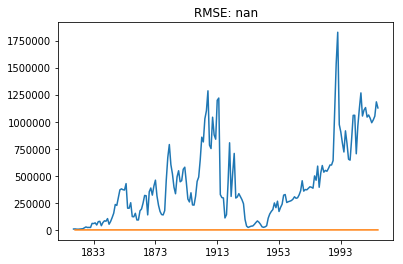

In [103]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts.Number)**2)/len(ts)))

In [1]:
# gdp = pd.read_html('https://www.thebalance.com/us-gdp-by-year-3305543')
# gdp[0]

In [126]:
gdp_df = pd.DataFrame(gdp[0])

In [128]:
type(gdp[0])

pandas.core.frame.DataFrame

In [142]:
# gdp = pd.read_csv('Data/USGDP_1790-2018.csv', skiprows=[0], header=1)
# gdp.head() 
# gdp = gdp[gdp.Year > 1819]
gdp.set_index('Year', inplace = True) #set index as year
gdp.index= gdp.index.astype(str) #change to str for date time format
gdp.index = pd.to_datetime(gdp.index)
gdp.head()

,Nominal GDP (million of Dollars),Real GDP (millions of 2012 dollars),GDP Deflator (index 2012=100),Population (in thousands),Nominal GDP per capita (current dollars),Real GDP per capita (year 2012 dollars)
Year,,,,,,
1820-01-01,710,"16,352",4.34,"9,618.00",73.82,"1,700.17"
1821-01-01,735,"17,223",4.27,"9,899.00",74.25,"1,739.84"
1822-01-01,805,"17,875",4.50,"10,189.00",79.01,"1,754.32"
1823-01-01,759,"18,522",4.10,"10,488.00",72.37,"1,765.97"
1824-01-01,754,"19,620",3.84,"10,795.00",69.85,"1,817.49"


In [145]:
# gdp.reset_index(drop=True, inplace=True)
# gdp.head() 
gdp = gdp[['Population (in thousands)', 'Real GDP per capita (year 2012 dollars)']]

In [146]:
gdp.head() 

,Population (in thousands),Real GDP per capita (year 2012 dollars)
Year,,
1820-01-01,"9,618.00","1,700.17"
1821-01-01,"9,899.00","1,739.84"
1822-01-01,"10,189.00","1,754.32"
1823-01-01,"10,488.00","1,765.97"
1824-01-01,"10,795.00","1,817.49"


In [159]:
ts = total_immigration


In [187]:
# gdp.join(ts)

joined = ts.join(gdp, how='inner')
joined.head()
# joined.columns

,Number,Population (in thousands),Real GDP per capita (year 2012 dollars)
Year,,,
1820-01-01,8385,"9,618.00","1,700.17"
1821-01-01,9127,"9,899.00","1,739.84"
1822-01-01,6911,"10,189.00","1,754.32"
1823-01-01,6354,"10,488.00","1,765.97"
1824-01-01,7912,"10,795.00","1,817.49"


In [192]:
joined['Pop_Perc'] = joined['Number'] / (joined['Population (in thousands)']*1000)
# joined['Population (in thousands)'] = pd.to_numeric(joined['Population (in thousands)'])
# joined['Number'] = pd.to_numeric(joined['Number'])
# pd.to_numeric(joined.iloc[0][1])
# joined.iloc[:,:].replace(',', '')
# joined[]

# joined = (joined.replace(',','', regex=True).astype(float))


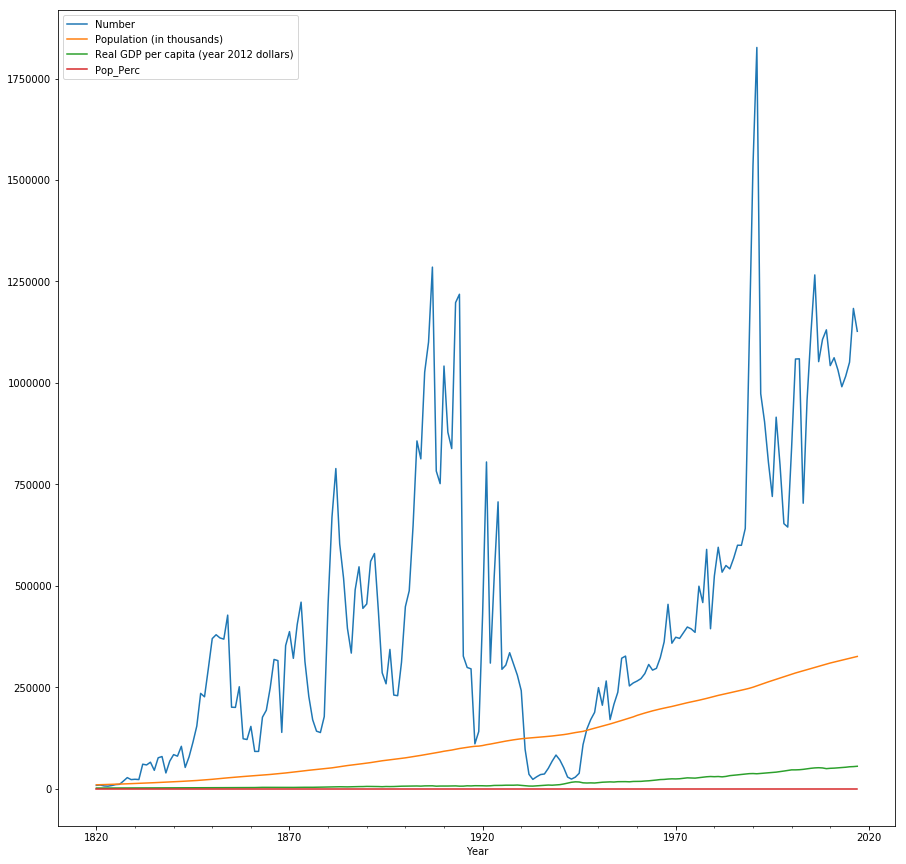

In [201]:

joined.plot(figsize=(15,15))


In [202]:
joined.tail(20)

,Number,Population (in thousands),Real GDP per capita (year 2012 dollars),Pop_Perc
Year,,,,
1998-01-01,653206.0,276154.0,43592.71,0.002365
1999-01-01,644787.0,279328.0,45145.85,0.002308
2000-01-01,841002.0,282398.0,46498.20,0.002978
2001-01-01,1058902.0,285225.0,46496.98,0.003713
2002-01-01,1059356.0,287955.0,46858.36,0.003679
2003-01-01,703542.0,290626.0,47755.88,0.002421
2004-01-01,957883.0,293262.0,49124.67,0.003266
2005-01-01,1122257.0,295993.0,50381.26,0.003791
2006-01-01,1266129.0,298818.0,51329.91,0.004237


In [203]:
joined.to_csv('pop_all.csv', index=False)